In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.io import savemat
import sys,os
sys.path.append("./Julia_allcodes_plus_dependencies/pyquest-master")
sys.path.append("./Tensor_paraproducts")
import diffusion_maps, organize_atten
from imports import *
import math
import questionnaire2 as q2coif
import questionnaire3 as q3coif
from scipy.spatial.distance import pdist, squareform
from scipy.io import savemat,loadmat
import pickle

In [6]:
def get_lyr_head(ptidx,hdplyr):

    # Channel axis of 3D tensor was organized by appending all heads for each layer sequentially, not appending all layer for one head
    # ptidx = index of head along channel axis
    # hdplyr = number of attention heads in each layer

    headidx = ptidx % hdplyr
    lyridx = math.floor(ptidx/hdplyr)
    
    return lyridx, headidx


iptidx = 100
out = get_lyr_head(iptidx,12)

# Organize Raw TXL/VIT Matrices

In [8]:
data = torch.load('./attentions_CIFAR/ViT_NORM_attentions_CIFAR_test_1_EP_finetune.pt')
print(len(data))

120


/tmp/ipykernel_1051967/1718849152.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('./attentions_CIFAR/ViT_NORM_attentions_CIFAR_test_1_EP_finetune.pt')

# Example on generating network 3-tensors

In [4]:
# TXL

datlist = [0,1,2,4,5,6]
batchidx = np.random.randint(0,len(datlist),1)[0]
batchidx = 4 #we know organization for this point is qualitatively nice a priori
X_txl = np.load("./attn_data/batch_" + str(batchidx) + "_tensor" + ".npy")



In [5]:
# VIT

npts = 10
data = torch.load('/home/of56/Documents/attentions_CIFAR_5_14.pt')
nvitlyr = 12
hdplyr = 12
batchidx = np.random.randint(0,npts,1)[0]*nvitlyr
dimhead = 197
cent = round(dimhead/2)


X_vit = np.zeros((128,128,nvitlyr*hdplyr))
c=0
for j in range(nvitlyr):
    vit_tensor = data[batchidx + j][1].numpy().astype(np.float64).squeeze()
    tens = np.transpose(vit_tensor, (1, 2, 0))[cent-64:cent+64:,cent-64:cent+64,:]
    X_vit[:,:,c:c + hdplyr] = tens
    c += 12




/tmp/ipykernel_1000878/2585609680.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/home/of56/Documents/attentions_CIFAR_5_14.pt')


# Compute VIT network entropies 

In [6]:


network_entp = []
vit_topfive_lh_net = []
vit_btmfive_lh_net = []
vit_topfive_lh_entp = []
vit_btmfive_lh_entp = []
topfive_lh = []
npts=6
for k in range(npts):


    nvitlyr = 12
    hdplyr = 12
    dimhead = 197
    cent = round(dimhead/2)
    batchidx = k*nvitlyr
    nhead = nvitlyr*hdplyr
    
    X_vit = np.zeros((128,128,nvitlyr*hdplyr))
    c=0
    for j in range(nvitlyr):
        vit_tensor = data[batchidx + j][1].numpy().astype(np.float64).squeeze()
        tens = np.transpose(vit_tensor, (1, 2, 0))[cent-64:cent+64:,cent-64:cent+64,:]
        X_vit[:,:,c:c + hdplyr] = tens
        c += 12

    
    # Organize Data
    iralph = 0
    irbeta = 1 
    icalph = 0
    icbeta = 1
    idalph = 0
    idbeta = 1
    initers = 3

    orgobj = organize_atten.organize_heads(X_vit)
    orgobj.init_quest_params(iralph,irbeta,icalph,icbeta,idalph,idbeta,initers)
    orgobj.run_quest()
    orgobj.run_diffusion()
    
    # Compute basis vectors
    inqb = 10
    inkb = 10
    orgobj.trihaar_proc(inqb,inkb)

    # compute l1 entropy of coefficients for each head in network
    entropies = []
    for j in range(nhead):
        hcoefs = []
        for i in range(len(orgobj.QKbases)):
            hcoefs.append(np.abs(np.sum(np.squeeze(X_vit[:,:,j]) * orgobj.QKbases[orgobj.suppidx[i]])))
        entropies.append(np.sum(hcoefs))

    vec = np.argsort(entropies)
    topfive = vec[-5:]
    btmfive = vec[:5]
    
    topfive_lh = []
    btmfive_lh = []
    
    for i in topfive:
        topfive_lh.append(get_lyr_head(i,hdplyr))
    
    for i in btmfive:
        btmfive_lh.append(get_lyr_head(i,hdplyr))



    # top/bottom five entropies for each network
    evec = np.sort(entropies)
    etopfive = evec[-5:]
    ebtmfive = evec[:5]
    

    network_entp.append(entropies)
    vit_topfive_lh_net.append(topfive_lh)
    vit_btmfive_lh_net.append(btmfive_lh)
    vit_topfive_lh_entp.append(etopfive)
    vit_btmfive_lh_entp.append(ebtmfive)

vit_network_entp = network_entp



# Compute TXL network entropies

In [7]:

txl_network_entp = []
txl_topfive_lh_net = []
txl_btmfive_lh_net = []
txl_topfive_lh_entp = []
txl_btmfive_lh_entp = []
topfive_lh = []
datlist = [0,1,2,4,5,6]
for k in datlist:


    X_txl = np.load("./attn_data/batch_" + str(k) + "_tensor" + ".npy")
    
    # Organize Data
    iralph = 0
    irbeta = 1 
    icalph = 0
    icbeta = 1
    idalph = 0
    idbeta = 1
    initers = 3

    orgobj = organize_atten.organize_heads(X_txl)
    orgobj.init_quest_params(iralph,irbeta,icalph,icbeta,idalph,idbeta,initers)
    orgobj.run_quest()
    orgobj.run_diffusion()
    
    # Compute basis vectors
    inqb = 10
    inkb = 10
    orgobj.trihaar_proc(inqb,inkb)

    # compute l1 entropy of coefficients for each head in network
    entropies = []
    nhead = 16*8
    for j in range(nhead):
        hcoefs = []
        for i in range(len(orgobj.QKbases)):
            hcoefs.append(np.abs(np.sum(np.squeeze(X_txl[:,:,j]) * orgobj.QKbases[orgobj.suppidx[i]])))
        entropies.append(np.sum(hcoefs))

    vec = np.argsort(entropies)
    topfive = vec[-5:]
    btmfive = vec[:5]
    
    topfive_lh = []
    btmfive_lh = []

    hdplyr = 8
    for i in topfive:
        topfive_lh.append(get_lyr_head(i,hdplyr))
    
    for i in btmfive:
        btmfive_lh.append(get_lyr_head(i,hdplyr))
        

    # top/bottom five entropies for each network
    evec = np.sort(entropies)
    etopfive = evec[-5:]
    ebtmfive = evec[:5]
    
    txl_network_entp.append(entropies)
    txl_topfive_lh_net.append(topfive_lh)
    txl_btmfive_lh_net.append(btmfive_lh)
    txl_topfive_lh_entp.append(etopfive)
    txl_topfive_lh_entp.append(ebtmfive)



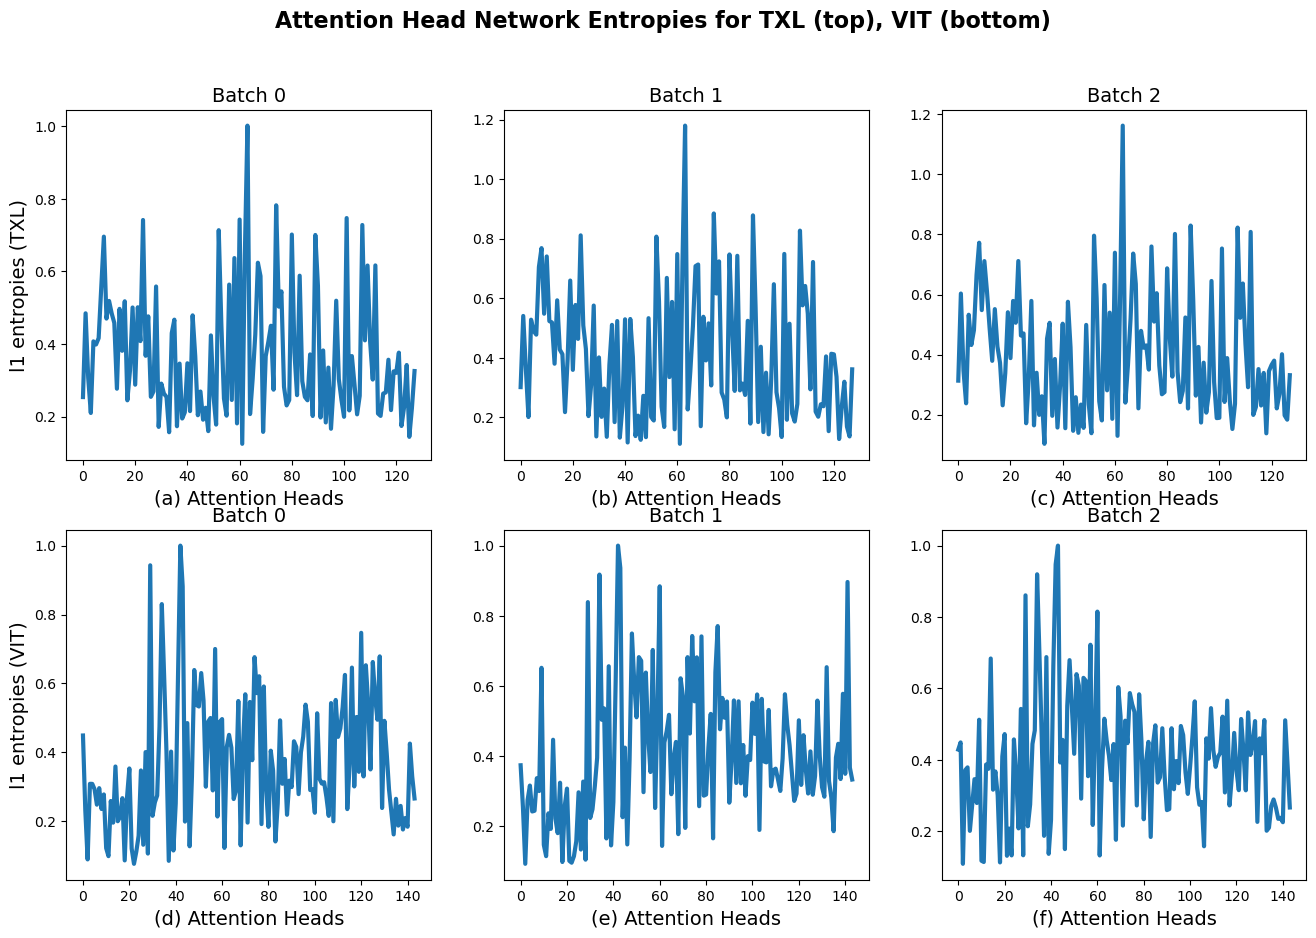

In [8]:



# Plott Entropies for 6 different networks
fig, axs = plt.subplots(2,3,figsize=(16,10))
plt.suptitle("Attention Head Network Entropies for TXL (top), VIT (bottom) ",fontsize=16,fontweight='bold')


axs[0,0].set_title("Batch 0",fontsize=14)
axs[0,0].plot(txl_network_entp[3]/np.max(txl_network_entp[0]),linewidth=3)
axs[0,0].set_xlabel("(a) Attention Heads",fontsize=14)
axs[0,0].set_ylabel("l1 entropies (TXL)",fontsize=14)

axs[0,1].set_title("Batch 1",fontsize=14)
axs[0,1].plot(txl_network_entp[4]/np.max(txl_network_entp[1]),linewidth=3)
axs[0,1].set_xlabel("(b) Attention Heads",fontsize=14)

axs[0,2].set_title("Batch 2",fontsize=14)
axs[0,2].plot(txl_network_entp[5]/np.max(txl_network_entp[2]),linewidth=3)
axs[0,2].set_xlabel("(c) Attention Heads",fontsize=14)

axs[1,0].set_title("Batch 0",fontsize=14)
axs[1,0].plot(vit_network_entp[3]/np.max(vit_network_entp[3]),linewidth=3)
axs[1,0].set_xlabel("(d) Attention Heads",fontsize=14)
axs[1,0].set_ylabel("l1 entropies (VIT)",fontsize=14)

axs[1,1].set_title("Batch 1",fontsize=14)
axs[1,1].plot(vit_network_entp[4]/np.max(vit_network_entp[4]),linewidth=3)
axs[1,1].set_xlabel("(e) Attention Heads",fontsize=14)

axs[1,2].set_title("Batch 2",fontsize=14)
axs[1,2].plot(vit_network_entp[5]/np.max(vit_network_entp[5]),linewidth=3)
axs[1,2].set_xlabel("(f) Attention Heads",fontsize=14)


plt.savefig("./questionnaire_experiments/network_entropies_5_16.png")



In [9]:

# Extract Mode of Layers/Heads in top 10%


def topbtm(networkentp,hdplyr,nhead):

    hdper = round(0.1*nhead)
    stxlnt = np.argsort(networkentp)
    tphds = [x[-hdper:] for x in stxlnt]
    btmhds = [x[:hdper] for x in stxlnt]
    tphds = np.array(np.concatenate(tphds))
    btmhds = np.array(np.concatenate(btmhds))
    
    tphdcnt = {}
    btmhdcnt = {}
    
    
    for i in tphds:
        tphdcnt[i] = 1 + tphdcnt.get(i,0)
    
    for i in btmhds:
        btmhdcnt[i] = 1 + btmhdcnt.get(i,0)
    
    tp_khds = sorted(tphdcnt, key=tphdcnt.get)[-3:]
    btm_khds = sorted(btmhdcnt, key=btmhdcnt.get)[-3:]
    
    
    
    tplyridx = []
    tphdidx = []
    tpcntval = []
    for i in range(3):
        a, b = get_lyr_head(tp_khds[i],hdplyr)
        tplyridx.append(a)
        tphdidx.append(b)
        tpcntval.append(tphdcnt[tp_khds[i]])
    
    
    btmlyridx = []
    btmhdidx = []
    btmcntval = []
    for i in range(3):
        a, b = get_lyr_head(btm_khds[i],hdplyr)
        btmlyridx.append(a)
        btmhdidx.append(b)
        btmcntval.append(btmhdcnt[btm_khds[i]])

    return [tplyridx,tphdidx,tpcntval,btmlyridx,btmhdidx,btmcntval]


ntxlhd = 128
txl_hdplyr = 8
txlout = topbtm(txl_network_entp,txl_hdplyr,ntxlhd)

nvithd = 144
vit_hdplyr = 12
vitout = topbtm(vit_network_entp,vit_hdplyr,nvithd)



Print out metrics for top and bout layer heads for TXL/VIT networks

In [10]:

"""
print(f"Top TXL layers: {txlout[0]}")
print(f"Top TXL heads: {txlout[1]}")
print(f"Top TXL count: {txlout[2]}")
"""

print(f"Bottom TXL layers: {txlout[3]}")
print(f"Bottom TXL heads: {txlout[4]}")
print(f"Bottom TXL count: {txlout[5]}")

"""
print(f"Top VIT layers: {vitout[0]}")
print(f"Top VIT heads: {vitout[1]}")
print(f"Top VIT count: {vitout[2]}")
"""

print(f"Bottom VIT layers: {vitout[3]}")
print(f"Bottom VIT heads: {vitout[4]}")
print(f"Bottom VIT count: {vitout[5]}")




Bottom TXL layers: [6, 7, 3]
Bottom TXL heads: [0, 5, 5]
Bottom TXL count: [6, 6, 6]
Bottom VIT layers: [2, 3, 1]
Bottom VIT heads: [4, 10, 11]
Bottom VIT count: [6, 6, 6]


# Part 2: Rerun 3D questionnaire, compute network entropies of tri-haar basis, other downstream visualizations

In [10]:


# TXL run
txlobj = organize_atten.organize_heads(X_txl)
txlobj.init_quest_params(iralph,irbeta,icalph,icbeta,idalph,idbeta,initers)
txlobj.run_quest()
txlobj.run_diffusion()


#VIT run
vitobj = organize_atten.organize_heads(X_vit)
vitobj.init_quest_params(iralph,irbeta,icalph,icbeta,idalph,idbeta,initers)
vitobj.run_quest()
vitobj.run_diffusion()


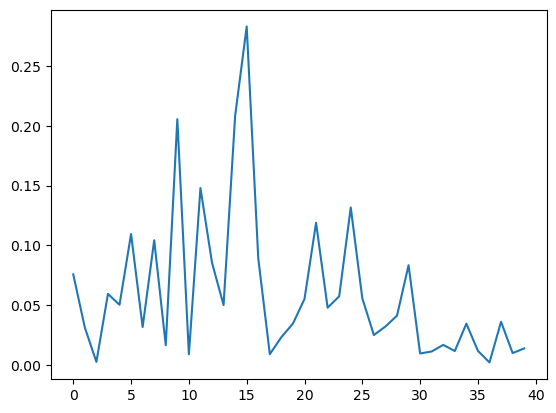

In [11]:

# Example
out = vitobj.compute_ntwk_entp(X_vit,40)

plt.figure()
plt.plot(out)

# Network projection into tri-haar basis

In [2]:

#Parameter Definition
iralph = 0
irbeta = 1 
icalph = 0
icbeta = 1
idalph = 0
idbeta = 1
initers = 3

a_vitentp = []
a_txlentp = []
datlist = [0,1,2,5,6]
data = torch.load('./attentions_CIFAR/ViT_NORM_attentions_CIFAR_test_1_EP_finetune.pt')


for k in range(len(datlist)):

    print(k)

    
    X_txl = np.load("./attn_data/batch_" + str(datlist[k]) + "_tensor" + ".npy")
    nvitlyr = 12
    hdplyr = 12
    dimhead = 197
    cent = round(dimhead/2)
    batchidx = k*nvitlyr
    nhead = nvitlyr*hdplyr
    
    X_vit = np.zeros((128,128,nvitlyr*hdplyr))
    c=0
    for j in range(nvitlyr):
        vit_tensor = data[batchidx + j][1].numpy().astype(np.float64).squeeze()
        tens = np.transpose(vit_tensor, (1, 2, 0))[cent-64:cent+64:,cent-64:cent+64,:]
        X_vit[:,:,c:c + hdplyr] = tens
        c += 12


    # TXL run
    txlobj = organize_atten.organize_heads(X_txl)
    txlobj.init_quest_params(iralph,irbeta,icalph,icbeta,idalph,idbeta,initers)
    txlobj.run_quest()
    txlobj.run_diffusion()
    
    
    #VIT run
    vitobj = organize_atten.organize_heads(X_vit)
    vitobj.init_quest_params(iralph,irbeta,icalph,icbeta,idalph,idbeta,initers)
    vitobj.run_quest()
    vitobj.run_diffusion()

    topk = 100
    a_vitentp.append(vitobj.compute_ntwk_entp(topk))
    a_txlentp.append(txlobj.compute_ntwk_entp(topk))
            


/tmp/ipykernel_1018656/3361730547.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/home/of56/Documents/attentions_CIFAR_5_14.pt')


0
1
2
3
4


In [4]:

# Save models

a_vitentp = np.array(a_vitentp)
a_txlentp = np.array(a_txlentp)

np.save("./network_tensor_data/vit_network_entropies.npy",a_vitentp)
np.save("./network_tensor_data/txl_network_entropies.npy",a_txlentp)



In [ ]:

# Reload models

a_vitentp = np.load("./network_tensor_data/vit_network_entropies.npy")
a_txlentp = np.load("./network_tensor_data/txl_network_entropies.npy")


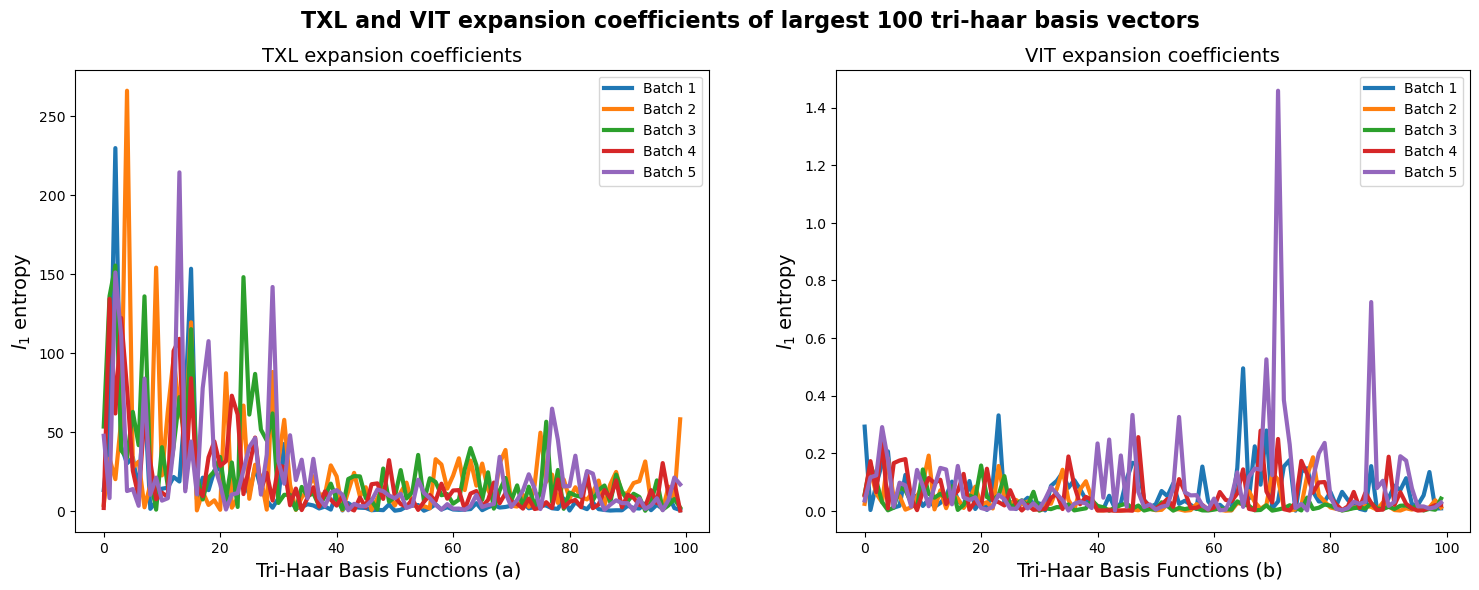

In [35]:


figs, axs = plt.subplots(1,2,figsize = (18,6))

plt.suptitle("TXL and VIT expansion coefficients of largest 100 tri-haar basis vectors",fontsize=16,fontweight='bold')

for i in range(5):
    axs[0].set_title("TXL expansion coefficients",fontsize=14)
    axs[0].plot(a_txlentp[i],linewidth=3)
    axs[0].set_xlabel("Tri-Haar Basis Functions (a) ",fontsize=14)
    axs[0].set_ylabel("$l_1$ entropy ",fontsize=14)
axs[0].legend(['Batch 1','Batch 2','Batch 3','Batch 4','Batch 5'])

for i in range(5):
    axs[1].set_title("VIT expansion coefficients",fontsize=14)
    axs[1].plot(a_vitentp[i],linewidth=3)
    axs[1].set_xlabel("Tri-Haar Basis Functions (b) ",fontsize=14)
    axs[1].set_ylabel("$l_1$ entropy ",fontsize=14)
axs[1].legend(['Batch 1','Batch 2','Batch 3','Batch 4','Batch 5'])

plt.savefig("./questionnaire_experiments/vit_txl_network_entropies")

In [21]:
# Print l1 Entropies

for i in range(5):
    print(f"TXL batch {i} entropy: {np.sum(a_txlentp[i]):.2f}")
    
print("")

for i in range(5):
    print(f"VIT batch {i} entropy: {np.sum(a_vitentp[i]):.2f}")


TXL batch 0 entropy: 1200.20
TXL batch 1 entropy: 2473.37
TXL batch 2 entropy: 2476.25
TXL batch 3 entropy: 1902.98
TXL batch 4 entropy: 2188.69

VIT batch 0 entropy: 6.84
VIT batch 1 entropy: 3.30
VIT batch 2 entropy: 2.47
VIT batch 3 entropy: 5.47
VIT batch 4 entropy: 9.77


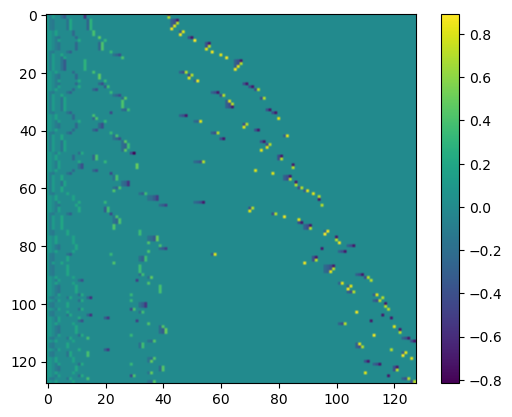

In [6]:
plt.figure()
plt.imshow(vitobj.QB)
plt.colorbar()

# Visualization of Networks

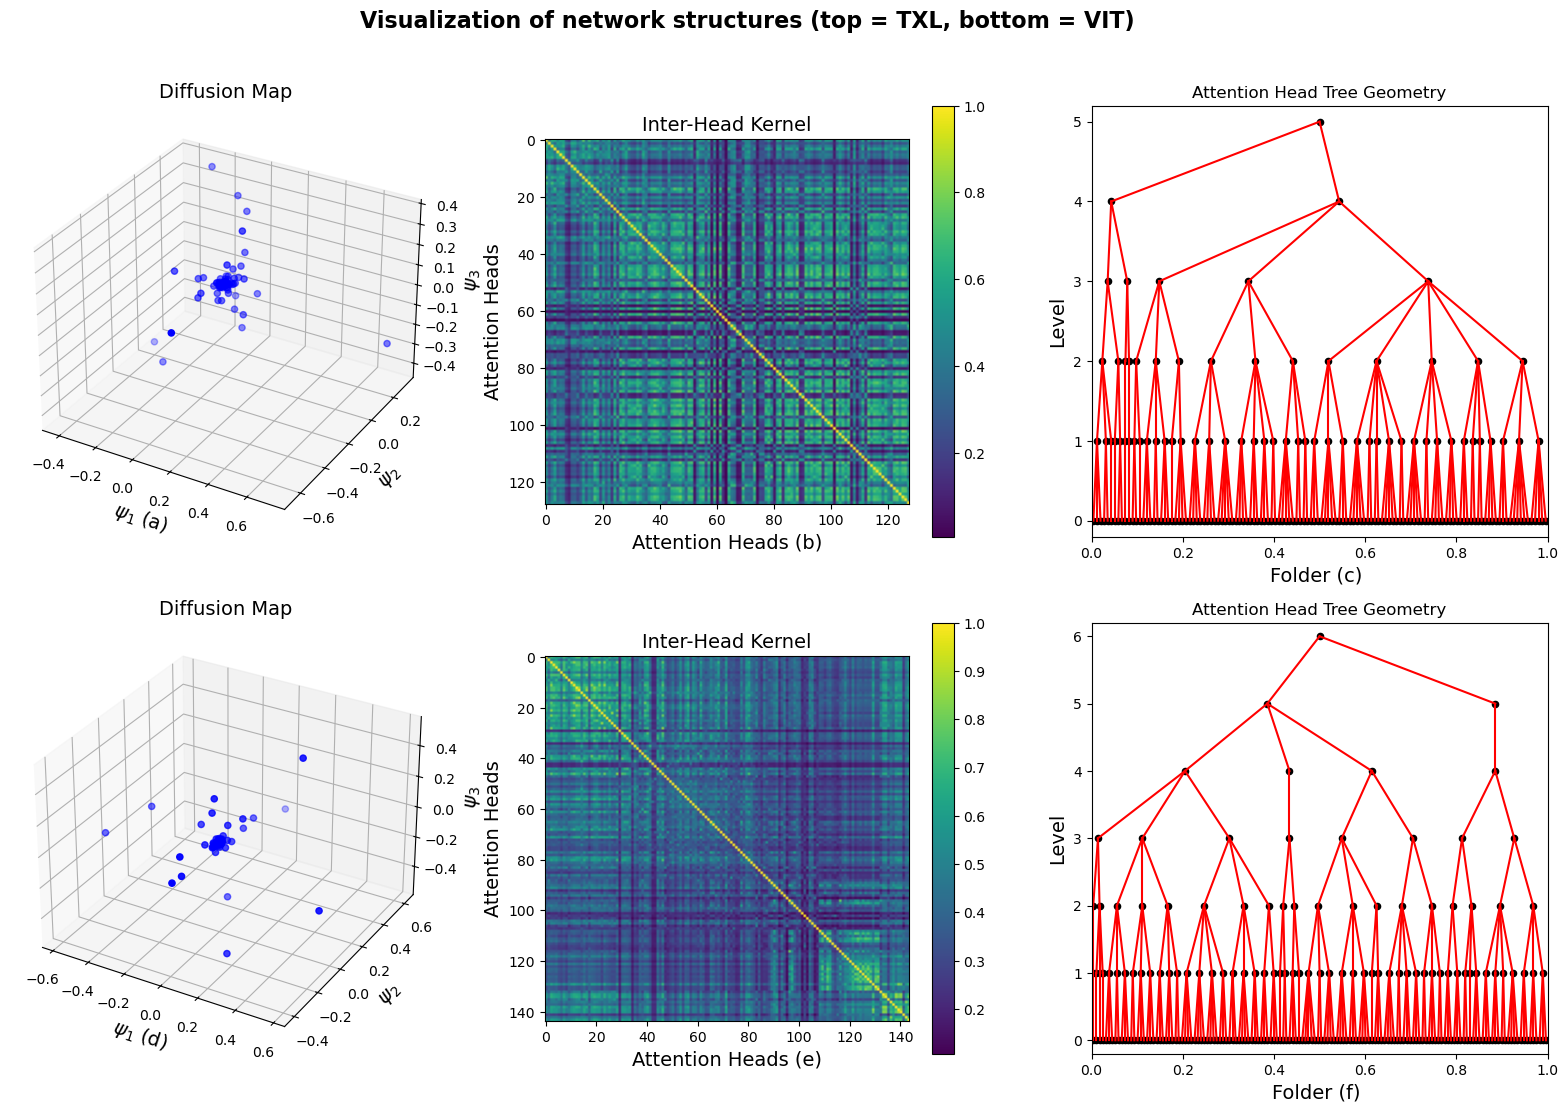

In [74]:



# Plotting
fig = plt.figure(figsize=(20, 12))
plt.subplots_adjust(top=0.9)  # Shrink plot area to leave space above
plt.suptitle(f"Visualization of network structures (top = TXL, bottom = VIT)",fontsize=16,fontweight='bold')

ax = fig.add_subplot(231, projection='3d')
ax.scatter(txlobj.firstvec, txlobj.secondvec, txlobj.thirdvec, c='blue', marker='o')
ax.set_title("Diffusion Map",fontsize=14)
ax.set_xlabel(" $\psi_1$ (a)",fontsize=14)
ax.set_ylabel(" $\psi_2$ ",fontsize=14)
ax.set_zlabel(" $\psi_3$",fontsize=14)


ax = fig.add_subplot(232)
img0 = ax.imshow(txlobj.chan_aff)
ax.set_title("Inter-Head Kernel",fontsize=14)
ax.set_xlabel("Attention Heads (b)",fontsize=14)
ax.set_ylabel("Attention Heads",fontsize=14)
fig.colorbar(img0, ax=ax)


ax = fig.add_subplot(233)
plot_tree(txlobj.chan_trees, title="Attention Head Tree Geometry", useplt=True,fontsize=14)
ax.set_xlabel("Folder (c) ",fontsize=14)
ax.set_ylabel("Level",fontsize=14)



ax = fig.add_subplot(234, projection='3d')
ax.scatter(vitobj.firstvec, vitobj.secondvec, vitobj.thirdvec, c='blue', marker='o')
ax.set_title("Diffusion Map",fontsize=14)
ax.set_xlabel(" $\psi_1$ (d) ",fontsize=14)
ax.set_ylabel(" $\psi_2$ ",fontsize=14)
ax.set_zlabel(" $\psi_3$",fontsize=14)

ax = fig.add_subplot(235)
img1 = ax.imshow(vitobj.chan_aff)
ax.set_title("Inter-Head Kernel",fontsize=14)
ax.set_xlabel("Attention Heads (e)",fontsize=14)
ax.set_ylabel("Attention Heads",fontsize=14)
fig.colorbar(img1, ax=ax)


ax = fig.add_subplot(236)
plot_tree(vitobj.chan_trees, title="Attention Head Tree Geometry", useplt=True,fontsize=14)
ax.set_xlabel("Folder (f) ",fontsize=14)
ax.set_ylabel("Level",fontsize=14)

plt.savefig("./questionnaire_experiments/txl_vit_visualization.png")




# Extract query and key basis vectors, visualize expansion coefficients for 2 heads in each model

In [80]:

ntxlhd = X_txl.shape[2]
txlhdidx = np.random.randint(0,ntxlhd)
txlhdidxtwo = np.random.randint(0,ntxlhd)

inqb = 20
inkb = 20
txlobj.trihaar_proc(inqb,inkb)

txlcoefs = []
for i in range(len(txlobj.QKbases)):
    txlcoefs.append(np.abs(np.sum(np.squeeze(X_txl[:,:,txlhdidx]) * txlobj.QKbases[txlobj.suppidx[i]])))

txlcoefstwo = []
for i in range(len(txlobj.QKbases)):
    txlcoefstwo.append(np.abs(np.sum(np.squeeze(X_txl[:,:,txlhdidxtwo]) * txlobj.QKbases[txlobj.suppidx[i]])))


nvithd = X_vit.shape[2]
vithdidx = np.random.randint(0,nvithd)
vithdidxtwo = np.random.randint(0,nvithd)

inqb = 20
inkb = 20
vitobj.trihaar_proc(inqb,inkb)

vitcoefs = []
for i in range(len(vitobj.QKbases)):
    vitcoefs.append(np.abs(np.sum(np.squeeze(X_vit[:,:,vithdidx]) * vitobj.QKbases[vitobj.suppidx[i]])))

vitcoefstwo = []
for i in range(len(vitobj.QKbases)):
    vitcoefstwo.append(np.abs(np.sum(np.squeeze(X_vit[:,:,vithdidxtwo]) * vitobj.QKbases[vitobj.suppidx[i]])))




In [102]:



ftxl_lyr,ftxl_hd = get_lyr_head(txlhdidx,8)
stxl_lyr,stxl_hd = get_lyr_head(txlhdidxtwo,8)
fvit_lyr,fvit_hd = get_lyr_head(vithdidx,12)
svit_lyr,svit_hd = get_lyr_head(vithdidxtwo,12)

    

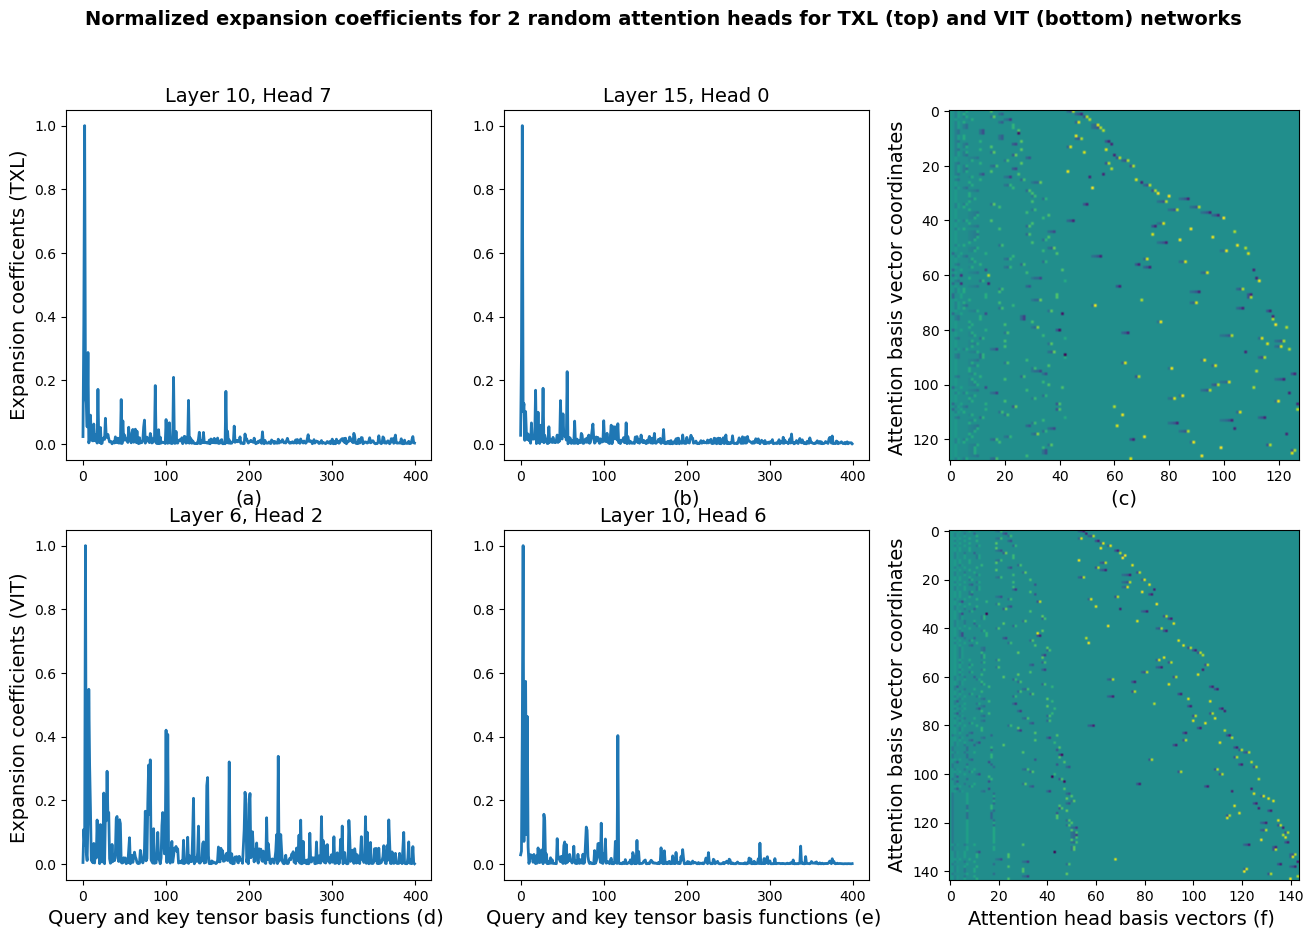

In [103]:


figs,axs = plt.subplots(2,3,figsize=(16,10))
plt.suptitle("Normalized expansion coefficients for 2 random attention heads for TXL (top) and VIT (bottom) networks ",fontsize=14,fontweight='bold')

axs[0,0].plot(txlcoefs/np.max(txlcoefs),linewidth=2)
axs[0,0].set_ylabel(" Expansion coefficents (TXL) ",fontsize=14)
axs[0,0].set_xlabel("(a)",fontsize=14)
axs[0,0].set_title(f"Layer {ftxl_lyr}, Head {ftxl_hd}",fontsize=14)
axs[0,1].plot(txlcoefstwo/np.max(txlcoefstwo),linewidth=2)
axs[0,1].set_xlabel("(b)",fontsize=14)
axs[0,1].set_title(f"Layer {stxl_lyr}, Head {stxl_hd}",fontsize=14)
axs[0,2].imshow(txlobj.CB)
axs[0,2].set_ylabel("Attention basis vector coordinates ",fontsize=14)
axs[0,2].set_xlabel(" (c) ",fontsize=14)



axs[1,0].plot(vitcoefs/np.max(vitcoefs),linewidth=2)
axs[1,0].set_title(f"Layer {fvit_lyr}, Head {fvit_hd} ",fontsize=14)
axs[1,0].set_xlabel("Query and key tensor basis functions (d) ",fontsize=14)
axs[1,0].set_ylabel("Expansion coefficients (VIT) ",fontsize=14)
axs[1,1].plot(vitcoefstwo/np.max(vitcoefstwo),linewidth=2)
axs[1,1].set_title(f"Layer {svit_lyr}, Head {svit_hd} ",fontsize=14)
axs[1,1].set_xlabel("Query and key tensor basis functions (e) ",fontsize=14)
axs[1,2].imshow(vitobj.CB)
axs[1,2].set_xlabel("Attention head basis vectors (f) ",fontsize=14)
axs[1,2].set_ylabel("Attention basis vector coordinates",fontsize=14)


plt.savefig("./questionnaire_experiments/expansion_coefficients.png")





In [122]:
# Create softmax tensor


dimtxl = 256
ntxlhd = 128
X_txl_sft = np.zeros((dimtxl,dimtxl,ntxlhd))

for j in range(ntxlhd):
    
    ftxl = np.exp(X_txl[:,:,0].squeeze())
    ftxlsft = np.zeros((dimtxl,dimtxl))
    rowsum = np.sum(ftxl,axis=1)
    for i in range(len(rowsum)):
        ftxlsft[i,:] = ftxl[i,:]/rowsum[i]
    X_txl_sft[:,:,j] = ftxlsft



In [124]:

#Generate tensor of Holder functions

## Parameters
switchcos = 1
kwargs = {}
kwargs["threshold"] = 0.0
kwargs["row_alpha"] = 1.0
kwargs["col_alpha"] = 1.0
kwargs["row_beta"] = 0.0
kwargs["col_beta"] = 0.0
kwargs["tree_constant"] = 1.0
kwargs["n_iters"] = 10 ##number of iterations


def runquest(A,switchver=False,switchcos = 0,**kwargs):

    if switchcos > 0:
        init_row_aff = affinity.mutual_cosine_similarity(A.T, threshold=0.0)
        init_col_aff = affinity.mutual_cosine_similarity(A, threshold=0.0)
        params = q2coif.PyQuestParams(q2coif.INIT_AFF_COS_SIM,
                                      q2coif.TREE_TYPE_FLEXIBLE,
                                      q2coif.DUAL_EMD,
                                      q2coif.DUAL_EMD, **kwargs)
    else:
        init_row_aff = affinity.gaussian_euclidean(A.T)
        init_col_aff = affinity.gaussian_euclidean(A)
        params = q2coif.PyQuestParams(q2coif.INIT_AFF_GAUSSIAN,
                                      q2coif.TREE_TYPE_FLEXIBLE,
                                      q2coif.DUAL_EMD,
                                      q2coif.DUAL_EMD, **kwargs)

    init_row_vecs, init_row_vals = markov.markov_eigs(init_row_aff, 12)
    init_col_vecs, init_col_vals = markov.markov_eigs(init_col_aff, 12)
    if switchver:
        qrun = q2coif.pyquest(A, params)
    else:
        qrun = q3coif.pyquest(A, params)
    return qrun


def return_holder(data):

    D = squareform(pdist(data))
    epsilon = np.sqrt(np.median(D))
    kwargs["epsilon"] = epsilon
    
    oqrun = runquest(data,False,switchcos,**kwargs) ## Questionnaire tree
    row_tree=oqrun.row_trees[-1]
    col_tree=oqrun.col_trees[-1]
    
    coifman_col_order = [x.elements[0]  for x in col_tree.dfs_leaves()]
    coifman_row_order = [x.elements[0] for x in row_tree.dfs_leaves()]
    data_afterquest=data[np.ix_(coifman_row_order,coifman_col_order)]

    return data_afterquest





In [ ]:



NX = dimtxl
NY = dimtxl
jmax = int(math.log2(NX) - 2)
jpmax = int(math.log2(NY) - 2)
jxrng = list(range(4,jmax)) # Define range of scales
jyrng = list(range(4,jpmax))
ivar = 'softmax'
X_txlapp = np.zeros((dimtxl,dimtxl,ntxlhd))

for j in range(ntxlhd):

    # Holder function
    fhold = return_holder(X_txl[:,:,j].squeeze())
    fholdsft = np.zeros((dimtxl,dimtxl))
    rowsum = np.sum(fhold,axis=1)
    for i in range(len(rowsum)):
        fholdsft[i,:] = fholdsft[i,:]/rowsum[i]
    
    #get tensor paraproduct decomposition 
    inst_decomp = tensor_paraproducts.tensor_paraproducts_haar(fhold,fholdsft,ivar)
    decompout = inst_decomp.paraproduct_decomp(jxrng,jyrng)
    totalapp = decompout['total']
    X_txlapp[:,:,j] = totalapp

    print(j)



In [127]:

np.save("Xtxl.npy",X_txl)
np.save("Xtxlsft.npy",X_txl_sft)
np.save("Xtxlapp.npy",X_txlapp)



In [37]:


otxl = np.load("./network_tensor_data/Xtxl.npy")
sftxl = np.load("./network_tensor_data/Xtxlsft.npy")
apptxl = np.load("./network_tensor_data/Xtxlapp.npy")



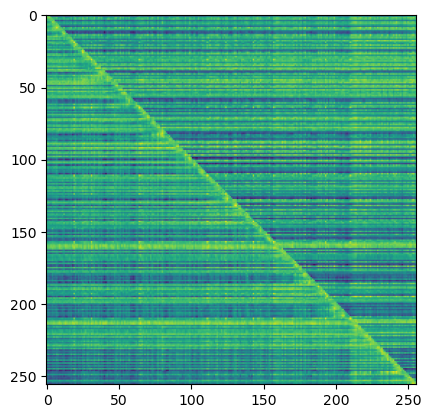

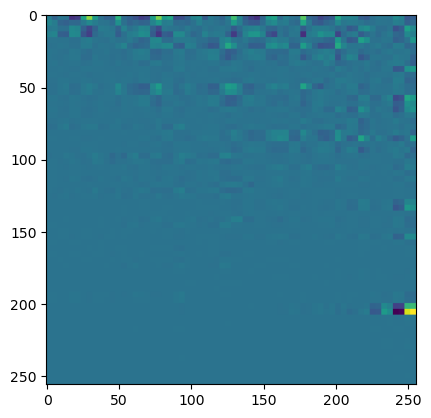

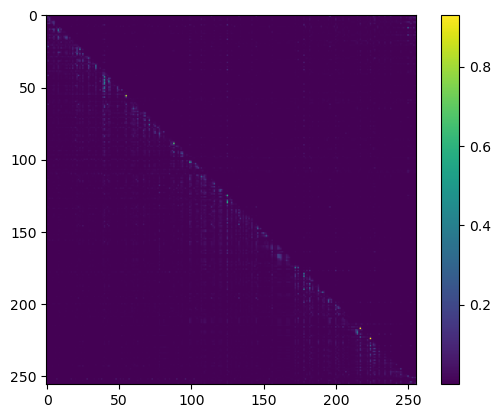

In [48]:

plt.figure()
plt.imshow(otxl[:,:,75])
plt.figure()
plt.imshow(apptxl[:,:,75])
plt.figure()
plt.imshow(sftxl[:,:,75])
plt.colorbar()



# Part 3: Run questionnaire on softmax, approximation, step before softmax for the attention heads

In [ ]:

print("Original")

#regular txl
txlobj = organize_atten.organize_heads(otxl)
txlobj.init_quest_params(iralph,irbeta,icalph,icbeta,idalph,idbeta,initers)
txlobj.run_quest()
txlobj.run_diffusion()

print("Softmax")


#sofmtax txl
txlsftobj = organize_atten.organize_heads(sftxl)
txlsftobj.init_quest_params(iralph,irbeta,icalph,icbeta,idalph,idbeta,initers)
txlsftobj.run_quest()
txlsftobj.run_diffusion()



print("Approximation")

#approximation txl
txlappobj = organize_atten.organize_heads(apptxl)
txlappobj.init_quest_params(iralph,irbeta,icalph,icbeta,idalph,idbeta,initers)
txlappobj.run_quest()
txlappobj.run_diffusion()



Original
Softmax
